In [17]:
### Convolutional Neural Network (CNN) Model Building (Training and Testing)

import tensorflow as tf

### this is the path of the data and labels
### for both training data set and testing
### data set 

path_train_img = '../data/training/img'
train_label = '../data/training/label/labels.txt'

### read the label txt file and unpack label
### information about each individual image 
### return a dictionary with image name and 
### label

def unpack_labels(label_path):
    labels = list()
    dict_ = dict()
    with open(label_path, 'r') as f:
        labels = f.readlines()
    
    for label in labels:
        img = label.split(':')[0]
        lbl = label.split(':')[1][2:][:-2]
        dict_[img] = lbl
        
    return dict_

train_label_dict = unpack_labels(train_label)

In [18]:
### for later model building
### one hot encoding 

def one_hot_encoding(img, dict_):
    import numpy as np

    if dict_[img] == 'airplane':
        ohl = np.array([1,0,0,0,0,0,0,0,0,0])
    elif dict_[img] == 'automobile':
        ohl = np.array([0,1,0,0,0,0,0,0,0,0])
    elif dict_[img] == 'bird':
        ohl = np.array([0,0,1,0,0,0,0,0,0,0])
    elif dict_[img] == 'cat':
        ohl = np.array([0,0,0,1,0,0,0,0,0,0])
    elif dict_[img] == 'deer':
        ohl = np.array([0,0,0,0,1,0,0,0,0,0])
    elif dict_[img] == 'dog':
        ohl = np.array([0,0,0,0,0,1,0,0,0,0])
    elif dict_[img] == 'frog':
        ohl = np.array([0,0,0,0,0,0,1,0,0,0])
    elif dict_[img] == 'horse':
        ohl = np.array([0,0,0,0,0,0,0,1,0,0])
    elif dict_[img] == 'ship':
        ohl = np.array([0,0,0,0,0,0,0,0,1,0])
    else:
        ohl = np.array([0,0,0,0,0,0,0,0,0,1])
        
    return ohl

In [28]:
def data_with_label(data_path, dict_):
    from tqdm import tqdm
    import os
    import numpy as np
    import cv2
    from random import shuffle
    
    imgs = []
    
    for i in tqdm(os.listdir(data_path)):
        path = os.path.join(data_path, i)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (32,32))
        imgs.append([np.array(img), one_hot_encoding(i, dict_)])
        
    shuffle(imgs)
    return imgs

In [12]:
train_data_with_label = data_with_label(path_train_img, train_label_dict)

100%|██████████| 50000/50000 [01:39<00:00, 501.70it/s]


In [20]:
def unzip_data(data_with_label):
    import numpy as np
    img_data_flat = np.array([d[0] for d in data_with_label]).reshape(-1, 32, 32, 1)
    lbl_data_flat = np.array([d[1] for d in data_with_label])
    return img_data_flat, lbl_data_flat

In [14]:
train_img_flat, train_lbl_flat = unzip_data(train_data_with_label)

In [21]:
### now we can start to build the machine learning model
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

def create_model():
    model = Sequential()
    model.add(InputLayer(input_shape = [32,32,1]))
    model.add(Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=5, padding='same'))

    model.add(Conv2D(filters=50, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=5, padding='same'))

    model.add(Conv2D(filters=80, kernel_size=5, strides=1, padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=5, padding='same'))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(10, activation='softmax'))
    optimizer = Adam(lr=1e-3)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
### train the model
print('training... approx. for an hour. Be patient')
model = create_model()
model.fit(x=train_img_flat, y=train_lbl_flat, epochs=50, batch_size=100, verbose=0)

training... approx. for an hour. Be patient


KeyboardInterrupt: 

In [ ]:
### evaluate the model based on training data 
scores = model.evaluate(train_img_flat, train_lbl_flat, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
### save the weights file
### serialize weights to HDF5
model.save_weights("../data/model/model.h5")
print("Saved model to disk")

In [22]:
### now we begin to test our cnn model by only using 
### the data for testing

path_test_img = '../data/testing/img'
test_label = '../data/testing/label/labels.txt'

test_label_dict = unpack_labels(test_label)
test_data_with_label = data_with_label(path_test_img, test_label_dict)
test_img_flat, test_lbl_flat = unzip_data(test_data_with_label)

100%|██████████| 10000/10000 [00:21<00:00, 464.06it/s]


In [23]:
### load the weights file so that we don't have to wait 
### until future training finishes. 

loaded_model = create_model()
# load weights into new model
loaded_model.load_weights("../data/model/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [46]:
# evaluate loaded model on test data
#loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(test_img_flat, test_lbl_flat, verbose=1)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

10000/10000 [==============================] - 5s 508us/step
acc: 63.60%


In [25]:
def one_hot_to_text(predict):
    if np.argmax(predict) == 0:
        predict_label = 'airplane'
    elif np.argmax(predict) == 1:
        predict_label = 'automobile'
    elif np.argmax(predict) == 2:
        predict_label = 'bird'
    elif np.argmax(predict) == 3:
        predict_label = 'cat'
    elif np.argmax(predict) == 4:
        predict_label = 'deer'
    elif np.argmax(predict) == 5:
        predict_label = 'dog'
    elif np.argmax(predict) == 6:
        predict_label = 'frog'
    elif np.argmax(predict) == 7:
        predict_label = 'horse'
    elif np.argmax(predict) == 8:
        predict_label = 'ship'
    else:
        predict_label = 'truck'
        
    return predict_label

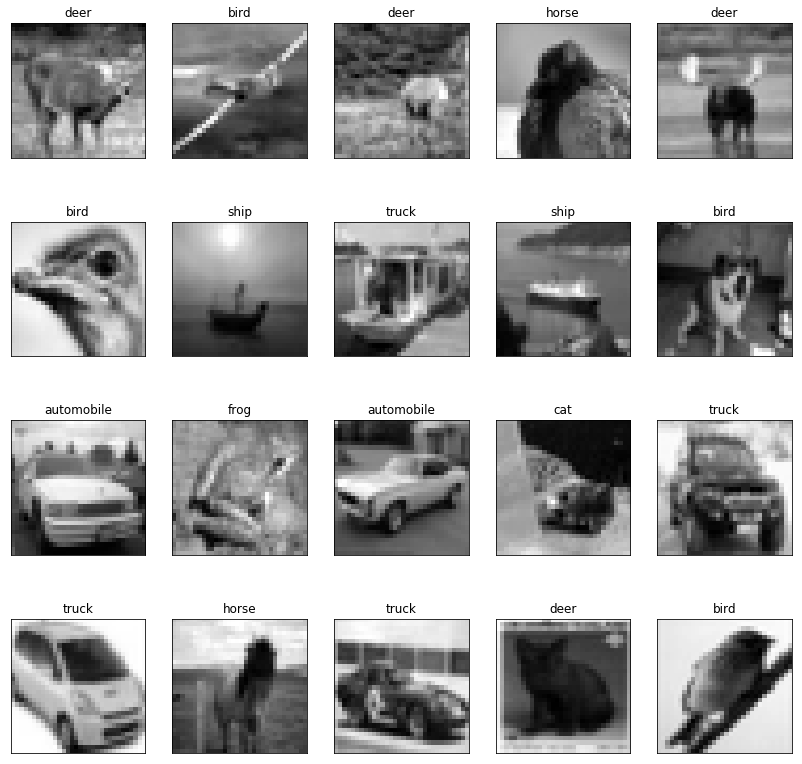

In [26]:
### track to see how well the model performs on untouched test data
### this is not a standard machine learning testing. It's just a 
### quick look if our model predicts something reasonable 
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(14,14))

for i, data in enumerate(test_data_with_label[10:30]):
    y = fig.add_subplot(4, 5, i+1)
    img = data[0]
    data = img.reshape(1,32,32,1)
    
    predict = loaded_model.predict([data])    
    predict_label = one_hot_to_text(predict)
    
    y.imshow(img, cmap='gray')
    plt.title(predict_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

In [40]:
def test_online_img(path, label):
    import cv2
    online_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    online_img = cv2.resize(online_img, (32,32))

    online_data = online_img.reshape(1,32,32,1)
    online_predict = loaded_model.predict([online_data])
    online_label = one_hot_to_text(online_predict)

    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.imshow(online_img, cmap='gray')
    plt.title(f'predicted: {online_label}\n actual: {label}')

In [59]:
online_path = '../data/online/'
online_imgs = ['cat-1.jpeg', 'frog-1.jpg', 'bird-1.jpeg',
              'automobile-1.jpeg', 'truck-1.jpeg', 'airplane-1.jpeg',
              'deer-1.jpeg', 'horse-1.jpeg', 'dog-1.jpeg']
online_labels = ['cat', 'frog', 'bird', 'automobile', 'truck', 'airplane',
                'deer', 'horse', 'dog']

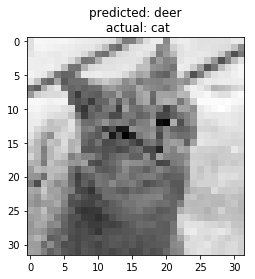

In [60]:
### test a online cat
test_online_img(online_path+online_imgs[0], 'cat')

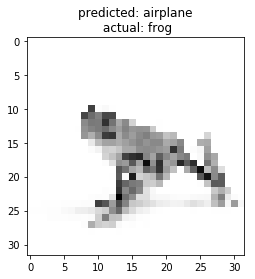

In [61]:
### test a online frog
test_online_img(online_path+online_imgs[1], 'frog')

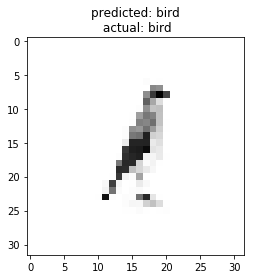

In [62]:
### test a online bird
test_online_img(online_path+online_imgs[2], 'bird')

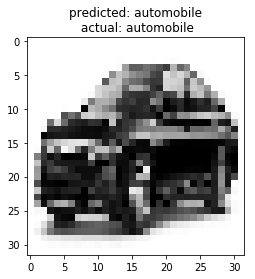

In [63]:
### test a online car
test_online_img(online_path+online_imgs[3], 'automobile')

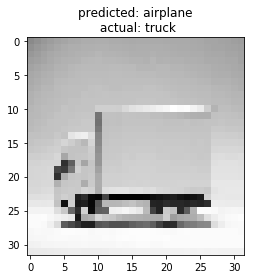

In [64]:
### test a online truck
test_online_img(online_path+online_imgs[4], 'truck')

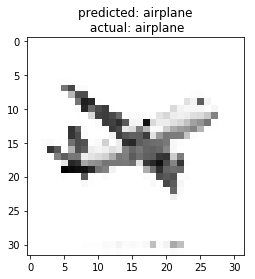

In [65]:
### test a online airplane
test_online_img(online_path+online_imgs[5], 'airplane')

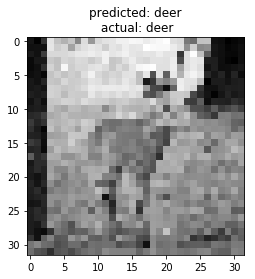

In [66]:
### test a online deer
test_online_img(online_path+online_imgs[6], 'deer')

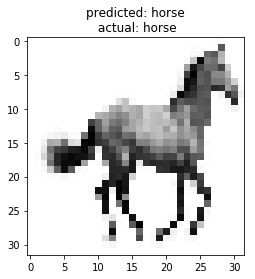

In [67]:
### test a online horse
test_online_img(online_path+online_imgs[7], 'horse')

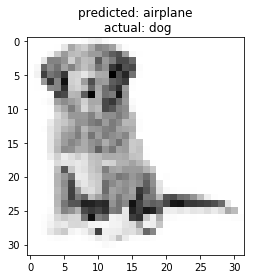

In [69]:
### test a online dog
test_online_img(online_path+online_imgs[8], 'dog')